<a href="https://colab.research.google.com/github/Erhuvwurhire/BackPocket-projects/blob/main/BackPocket_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sample Interactions Data:
  user_id product_id  rating
0    U001       P018       4
1    U001       P012       4
2    U001       P008       4
3    U001       P034       4
4    U001       P046       3

Sample Products Data:
  product_id    category  price  popularity
0       P001     Gadgets  43.71          93
1       P002  Home Decor  26.51          72
2       P003       Books  63.88          83
3       P004     Gadgets  19.00          75
4       P005     Gadgets  87.96          24

Top recommendations for user U001:
product_id
P041      Books - P041
P007       Toys - P007
P014      Books - P014
P009      Books - P009
P027    Gadgets - P027
Name: product_id, dtype: object


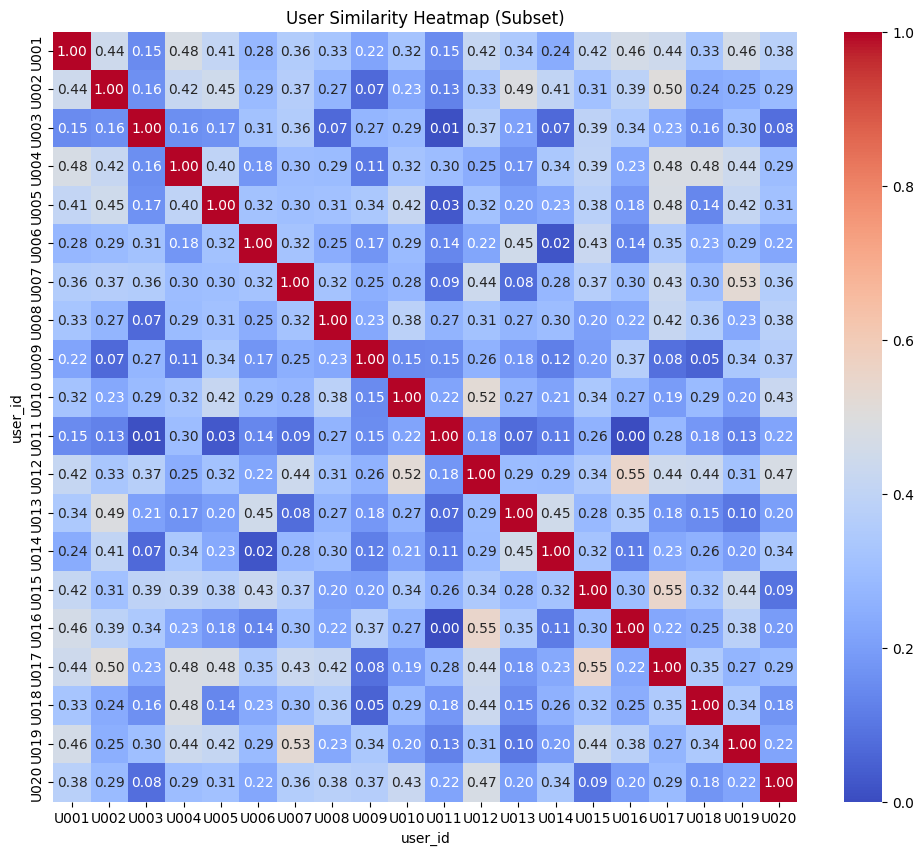

In [7]:
# BackPocket Gifting Recommender - Project 1
# ML Project: Personalized Gift Recommendation using Collaborative Filtering

# 📦 Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# 🔧 Step 2: Load the Data
# Load the user-product interactions data
interactions_df = pd.read_csv('data/user_product_interactions.csv')
print("Sample Interactions Data:")
print(interactions_df.head())

# Load the product data (optional, but good for getting product names)
products_df = pd.read_csv('data/products.csv')
print("\nSample Products Data:")
print(products_df.head())


# 🧹 Step 3: Preprocessing
# Create a user-item matrix for collaborative filtering using interactions_df
user_item_matrix = interactions_df.pivot_table(index='user_id', columns='product_id', values='rating').fillna(0)

# Calculate similarity matrix between users
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# 🤝 Step 4: Collaborative Filtering Prediction Function
def predict_ratings(user_id):
    if user_id not in user_item_matrix.index:
        print(f"User {user_id} not found in the matrix.")
        return pd.Series([], index=user_item_matrix.columns)

    similar_users = user_similarity_df[user_id].sort_values(ascending=False)
    # Exclude the user itself from the similarity calculation
    similar_users = similar_users.drop(user_id)

    # Ensure similar_users and user_item_matrix are aligned
    aligned_user_item_matrix = user_item_matrix.loc[similar_users.index]

    # Perform weighted sum and sum of similarities only for users with similarity > 0
    positive_similarity_users = similar_users[similar_users > 0]
    if positive_similarity_users.empty:
        return pd.Series(0, index=user_item_matrix.columns)

    weighted_sum = np.dot(positive_similarity_users.values, aligned_user_item_matrix.loc[positive_similarity_users.index].values)
    sim_sum = positive_similarity_users.sum()

    # Avoid division by zero
    predicted_ratings = weighted_sum / sim_sum if sim_sum != 0 else np.zeros_like(weighted_sum)

    return pd.Series(predicted_ratings, index=user_item_matrix.columns)


# 🎯 Step 5: Make Recommendations
def recommend_products(user_id, top_n=5):
    predictions = predict_ratings(user_id)
    if predictions.empty:
        return pd.Series([]) # Return empty Series if no predictions

    if user_id in user_item_matrix.index:
        user_rated = user_item_matrix.loc[user_id]
        unrated_products = predictions[user_rated == 0]
    else:
        # If user is not in the matrix, recommend based on predictions for all products
        unrated_products = predictions

    top_recommendations = unrated_products.sort_values(ascending=False).head(top_n)

    # Optionally, map product_id to product_name if products_df is loaded
    if 'products_df' in globals():
        product_details = products_df.set_index('product_id')
        recommended_product_names = top_recommendations.index.map(
            lambda product_id: f"{product_details.loc[product_id, 'category']} - {product_id}" if product_id in product_details.index else product_id
        )
        recommended_products_series = pd.Series(recommended_product_names, index=top_recommendations.index)
        return recommended_products_series
    else:
        return top_recommendations


# Example Recommendation
# Use a user_id that exists in the interactions_df
example_user_id = interactions_df['user_id'].iloc[0]
print(f"\nTop recommendations for user {example_user_id}:")
recommendations = recommend_products(example_user_id)
print(recommendations)


# 📊 Optional: Visualize Similarity Matrix
# Due to potential large size, visualize only a subset if needed
if user_similarity_df.shape[0] > 20:
    subset_users = user_similarity_df.index[:20]
    plt.figure(figsize=(12, 10))
    sns.heatmap(user_similarity_df.loc[subset_users, subset_users], cmap='coolwarm', annot=True, fmt=".2f")
    plt.title('User Similarity Heatmap (Subset)')
    plt.show()
else:
    plt.figure(figsize=(10, 8))
    sns.heatmap(user_similarity_df, cmap='coolwarm')
    plt.title('User Similarity Heatmap')
    plt.show()